# H100

# Global preparations

In [4]:
import sys
import os
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import logging
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from tqdm.notebook import tqdm

sys.path.insert(0, os.path.expanduser('~/andn'))
device = 'cuda'
summation_dtype = torch.float32
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = False

In [5]:
n_subnets = 1000
Ne = 800  # excitatory neurons
Ni = 200 # inhibitory neurons
N = Ne + Ni  # total neurons
M = 100  # synapses per neuron

In [6]:
from spiky.util.synapse_growth import SynapseGrowthEngine, UniformSamplingGrowthCommand, GrowthCommand
# Create growth engine
growth_engine = SynapseGrowthEngine(
    device=device,
    synapse_group_size=((M + 31) // 32) * 32,
    max_groups_in_buffer=((N + 31) // 32) * 32 * n_subnets
)

In [7]:
# Define growth commands
# Command 1: Connect excitatory to excitatory neurons
e_to_e_target_command = GrowthCommand(
    target_type=0,  # Connect to neurons of type 0
    synapse_meta_index=0,  # Synapse type 0
    x1=-100.0, y1=-100.0, z1=-100.0,  # Large cuboid area
    x2=100.0, y2=100.0, z2=100.0,  # covering all possible positions in the subnet
    p=0.1,  # 10% connection probability
    max_synapses=int((Ne / N) * M)
)

# Command 1: Connect excitatory to inhibitory neurons
e_to_i_target_command = GrowthCommand(
    target_type=1,  # Target inhibitory neurons (type 1)
    synapse_meta_index=0,
    x1=-100.0, y1=-100.0, z1=-100.0,  # Large cuboid area
    x2=100.0, y2=100.0, z2=100.0,  # covering all possible positions in the subnet
    p=0.1,  # 10% connection probability
    max_synapses=int((Ni / N) * M)
)

# Each excitatory neuron can have up to 100 synapses

# Command 2: Connect inhibitory to excitatory neurons (type 0)
i_to_e_target_command = GrowthCommand(
    target_type=0,  # Target excitatory neurons (type 0)
    synapse_meta_index=1,
    x1=-100.0, y1=-100.0, z1=-100.0,  # Large cuboid area
    x2=100.0, y2=100.0, z2=100.0,  # covering all possible positions in the subnet
    p=0.1,  # 10% connection probability
    max_synapses=M
)
e_to_e_target_command, e_to_i_target_command, i_to_e_target_command

(GrowthCommand(target_type=0, synapse_meta_index=0, x1=-100.0, y1=-100.0, z1=-100.0, x2=100.0, y2=100.0, z2=100.0, p=0.1, max_synapses=80),
 GrowthCommand(target_type=1, synapse_meta_index=0, x1=-100.0, y1=-100.0, z1=-100.0, x2=100.0, y2=100.0, z2=100.0, p=0.1, max_synapses=20),
 GrowthCommand(target_type=0, synapse_meta_index=1, x1=-100.0, y1=-100.0, z1=-100.0, x2=100.0, y2=100.0, z2=100.0, p=0.1, max_synapses=100))

In [8]:
# Register neuron types
growth_engine.register_neuron_type(
    max_synapses=N // 10,
    growth_command_list=[e_to_e_target_command, e_to_i_target_command]  # Can connect to both types
)

growth_engine.register_neuron_type(
    max_synapses=Ne // 10,
    growth_command_list=[i_to_e_target_command]  # Can only connect to excitatory neurons
)

1

In [9]:
from spiky.spnet.spnet import SpikingNet, SynapseMeta, NeuronMeta
# Creating spiking network
synapse_metas = [
    SynapseMeta(
        learning_rate=0.1,
        min_delay=0,
        max_delay=19,
        initial_weight=6.0,
        _forward_group_size=8,
        _backward_group_size=8
    ),
    SynapseMeta(
        learning_rate=0.0,
        min_delay=0,
        max_delay=0,
        min_weight=-5.0,
        max_weight=-5.0,
        initial_weight=-5.0,
        _forward_group_size=128,
        _backward_group_size=128
    ),
]
neuron_metas = [
    NeuronMeta(
        neuron_type=0,
        a=0.02,
        d=8.0
    ),
    NeuronMeta(
        neuron_type=1,
        a=0.1,
        d=2.0
    )
]
spnet = SpikingNet(
    synapse_metas=synapse_metas,
    neuron_metas=neuron_metas,
    neuron_counts=[
        Ne * n_subnets, Ni * n_subnets
    ],
    initial_synapse_capacity=M * N,
    summation_dtype=summation_dtype
)
spnet.to_device(device)
spnet

SpikingNet(1000000 neurons, 0 synapses, SPNetDataManager(host_device: 57223256, 57223256; host_only: 1024, 152; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 0; max_delay: 19; first_synapse_id: 0; last_synapse_id: 0; n_forward_groups: 0; n_backward_groups: 0))

In [10]:
excitatory_ids = spnet.get_neuron_ids_by_meta(0)
inhibitory_ids = spnet.get_neuron_ids_by_meta(1)
excitatory_ids.shape, inhibitory_ids.shape

(torch.Size([800000]), torch.Size([200000]))

In [11]:
excitatory_coords = []
inhibitory_coords = []

current_shift = 0.0

for _ in range(n_subnets):
    rows = (torch.arange(Ne).float() / Ne) * 99.0 + current_shift
    cols = torch.zeros_like(rows)
    excitatory_coords.append(
        torch.stack([cols, torch.zeros(Ne), rows], dim=1)
    )
    
    rows = (torch.arange(Ni).float() / Ni) * 99.0 + current_shift
    cols = torch.zeros_like(rows)
    inhibitory_coords.append(
        torch.stack([cols, torch.ones(Ni), rows], dim=1)
    )

    current_shift += 1000.0

excitatory_coords = torch.cat(excitatory_coords, dim=0)
inhibitory_coords = torch.cat(inhibitory_coords, dim=0)
excitatory_coords.shape, inhibitory_coords.shape, excitatory_coords.max(), inhibitory_coords.max()

(torch.Size([800000, 3]),
 torch.Size([200000, 3]),
 tensor(999098.8750),
 tensor(999098.5000))

In [12]:
# growing spiking network
growth_engine.add_neurons(neuron_type_index=0, identifiers=excitatory_ids, coordinates=excitatory_coords)
growth_engine.add_neurons(neuron_type_index=1, identifiers=inhibitory_ids, coordinates=inhibitory_coords)
growth_engine._max_neuron_id

1000003

In [13]:
chunk_of_connections = growth_engine.grow(random_seed)
chunk_of_connections.get_connections().shape

torch.Size([266240000])

In [14]:
len(growth_engine._neuron_types)

2

In [15]:
print(growth_engine.get_profiling_stats())

synapse_growth::import_growth_commands: 3.79756 ms / 2 = 1.89878 ms
synapse_growth::import_neuron_coords: 0.071357 ms / 2 = 0.0356785 ms
synapse_growth::rng_setup: 3.09904 ms / 1 = 3.09904 ms
synapse_growth::grow_synapses: 11.7251 ms / 1 = 11.7251 ms
synapse_growth::merge_chains: 0.08114 ms / 1 = 0.08114 ms
synapse_growth::sort_chains_by_synapse_meta: 0.101132 ms / 1 = 0.101132 ms
synapse_growth::final_sort: 137.046 ms / 1 = 137.046 ms



In [16]:
spnet.add_connections(chunk_of_connections, random_seed)
spnet

SpikingNet(1000000 neurons, 91222050 synapses, SPNetDataManager(host_device: 1374899484, 916599656; host_only: 1024, 152; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 91222050; max_delay: 19; first_synapse_id: 0; last_synapse_id: 0; n_forward_groups: 0; n_backward_groups: 0))

In [17]:
print(spnet.get_profiling_stats())

connections_manager::add_connections: 15.8224 ms / 1 = 15.8224 ms
connections_manager::add_connections::estimate_capacity: 6.92426 ms / 1 = 6.92426 ms
connections_manager::add_connections::create_groups: 6.11274 ms / 1 = 6.11274 ms
connections_manager::finalize_groups: 0 ms / 0 = -nan ms
connections_manager::finalize_groups::gather_forward_info: 0 ms / 0 = -nan ms
connections_manager::finalize_groups::shuffle_groups: 0 ms / 0 = -nan ms
connections_manager::finalize_groups::calculate_backward_stats: 0 ms / 0 = -nan ms
connections_manager::finalize_groups::reduce_backward_stats: 0 ms / 0 = -nan ms
connections_manager::finalize_groups::calculate_backward_counters: 0 ms / 0 = -nan ms
connections_manager::finalize_groups::reduce_backward_counters: 0 ms / 0 = -nan ms
connections_manager::finalize_groups::reduce_backward_capacity: 0 ms / 0 = -nan ms
connections_manager::finalize_groups::distribute_big: 0 ms / 0 = -nan ms
connections_manager::finalize_groups::distribute_small: 0 ms / 0 = -nan 

In [18]:
chunk_of_connections.recycle()

In [19]:
spnet.compile(shuffle_synapses_random_seed=random_seed)
# spnet.compile(shuffle_synapses_random_seed=None)
print(spnet)
print(spnet.get_memory_stats())
print(spnet.get_profiling_stats())

SpikingNet(1000000 neurons, 91222050 synapses, SPNetDataManager(host_device: 2523730812, 1827039088; host_only: 1024, 152; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 91222050; max_delay: 19; first_synapse_id: 57223264; last_synapse_id: 792413608; n_forward_groups: 16200000; n_backward_groups: 19837149))
forward main synapses: 839234 KB
backward synapses: 747937 KB
delays info: 141163 KB
synapse metas: 192 KB
neuron metas: 25 KB
neuron infos: 55664 KB

connections_manager::add_connections: 15.8224 ms / 1 = 15.8224 ms
connections_manager::add_connections::estimate_capacity: 6.92426 ms / 1 = 6.92426 ms
connections_manager::add_connections::create_groups: 6.11274 ms / 1 = 6.11274 ms
connections_manager::finalize_groups: 276.208 ms / 1 = 276.208 ms
connections_manager::finalize_groups::gather_forward_info: 3.3502 ms / 1 = 3.3502 ms
connections_manager::finalize_groups::shuffle_groups: 17.6996 ms / 1 = 17.6996 ms
connections_manager::finalize_groups::calculate

In [20]:
spnet.to_device('cpu')

In [21]:
spnet.to_device(device)
spnet

SpikingNet(1000000 neurons, 91222050 synapses, SPNetDataManager(host_device: 1827039088, 1827039088; host_only: 1024, 152; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 91222050; max_delay: 19; first_synapse_id: 57223264; last_synapse_id: 792413608; n_forward_groups: 16200000; n_backward_groups: 19837149))

In [22]:
n_ticks = 1000
batch_size = 1
input_ids = torch.cat([excitatory_ids, inhibitory_ids])
subnet_shifts = torch.arange(0, n_subnets, device=device).unsqueeze(0).unsqueeze(0) * N

def generate_random_sparse_input():
    spikes = torch.randint(N, [1, n_ticks, n_subnets], device=device, dtype=torch.int32)
    spikes += subnet_shifts
    values = torch.ones_like(spikes, dtype=torch.float32, device=device) * 20.0
    return spikes.repeat(batch_size, 1, 1), values.repeat(batch_size, 1, 1)

def randomise_sparse_input_in_place(spikes_buf):
    spikes_buf.random_(0, N)
    spikes_buf += subnet_shifts

In [23]:
sparse_input, sparse_input_values = generate_random_sparse_input()
sparse_input.shape, sparse_input.shape

(torch.Size([1, 1000, 1000]), torch.Size([1, 1000, 1000]))

In [24]:
spnet.reset_profiler()
n_spikes = spnet.process_ticks(
    n_ticks_to_process=n_ticks,
    batch_size=batch_size,
    n_input_ticks=n_ticks,
    input_values=sparse_input_values,
    do_train=False,
    sparse_input=sparse_input,
    do_record_voltage=False,
    do_reset_context=False,
    _stdp_period=32
)

print(f"{n_spikes} spikes generated")
print(spnet)
print(spnet.get_memory_stats())
print(spnet.get_profiling_stats())

12082992 spikes generated
SpikingNet(1000000 neurons, 91222050 synapses, SPNetDataManager(host_device: 1827039088, 1827039088; host_only: 1024, 152; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 91222050; max_delay: 19; first_synapse_id: 57223264; last_synapse_id: 792413608; n_forward_groups: 16200000; n_backward_groups: 19837149))
forward main synapses: 839234 KB
backward synapses: 747937 KB
delays info: 141163 KB
synapse metas: 192 KB
neuron metas: 25 KB
neuron infos: 55664 KB

connections_manager::add_connections: 0 ms / 0 = -nan ms
connections_manager::add_connections::estimate_capacity: 0 ms / 0 = -nan ms
connections_manager::add_connections::create_groups: 0 ms / 0 = -nan ms
connections_manager::finalize_groups: 0 ms / 0 = -nan ms
connections_manager::finalize_groups::gather_forward_info: 0 ms / 0 = -nan ms
connections_manager::finalize_groups::shuffle_groups: 0 ms / 0 = -nan ms
connections_manager::finalize_groups::calculate_backward_stats: 0 ms / 0 

In [27]:
import re

def extract_process_tick_value(big_str: str):
    m = re.search(r"process_tick[^=]*=\s*([0-9.]+)", big_str)
    return float(m.group(1)) if m else None

In [28]:
spnet.reset_profiler()
process_ticks_timings = []
n_spikes = []
for i in tqdm(range(100)):
    n_spikes.append(
        spnet.process_ticks(
            n_ticks_to_process=n_ticks,
            batch_size=batch_size,
            n_input_ticks=n_ticks,
            input_values=sparse_input_values,
            do_train=True,
            sparse_input=sparse_input,
            do_record_voltage=False,
            do_reset_context=False,
            _stdp_period=32
        )
    )
    process_ticks_timings.append(extract_process_tick_value(spnet.get_profiling_stats()))
    randomise_sparse_input_in_place(sparse_input)
    

print(spnet)
print(spnet.get_memory_stats())
print(spnet.get_profiling_stats())

  0%|          | 0/100 [00:00<?, ?it/s]

SpikingNet(1000000 neurons, 91222050 synapses, SPNetDataManager(host_device: 1827039088, 1827039088; host_only: 1024, 152; summation type: float32; smallest distinguishable fraction: 0; n_synapses: 91222050; max_delay: 19; first_synapse_id: 57223264; last_synapse_id: 792413608; n_forward_groups: 16200000; n_backward_groups: 19837149))
forward main synapses: 839234 KB
backward synapses: 747937 KB
delays info: 141163 KB
synapse metas: 192 KB
neuron metas: 25 KB
neuron infos: 55664 KB

connections_manager::add_connections: 0 ms / 0 = -nan ms
connections_manager::add_connections::estimate_capacity: 0 ms / 0 = -nan ms
connections_manager::add_connections::create_groups: 0 ms / 0 = -nan ms
connections_manager::finalize_groups: 0 ms / 0 = -nan ms
connections_manager::finalize_groups::gather_forward_info: 0 ms / 0 = -nan ms
connections_manager::finalize_groups::shuffle_groups: 0 ms / 0 = -nan ms
connections_manager::finalize_groups::calculate_backward_stats: 0 ms / 0 = -nan ms
connections_mana

In [ ]:
import matplotlib.pyplot as plt

plt.plot(process_ticks_timings)
plt.show()

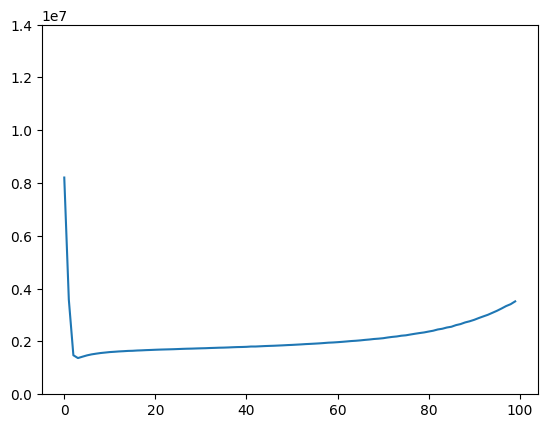

In [30]:
plt.plot(n_spikes)
plt.ylim(0, 14000000)
plt.show()

In [ ]:
0.192 / 0.124

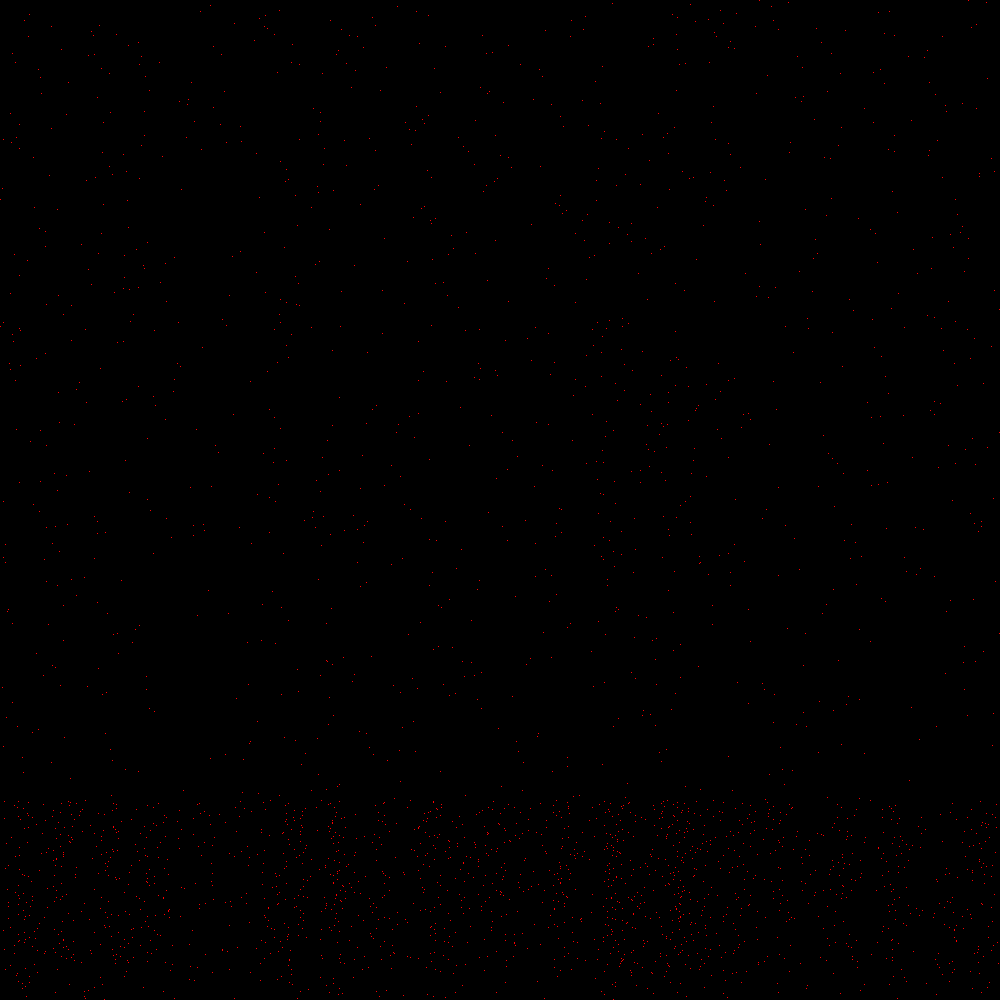

In [29]:
from spiky.spnet.spnet import NeuronDataType

subnet_idx = 745
ids_sample = torch.cat(
    [
        input_ids[subnet_idx * Ne:(subnet_idx + 1) * Ne],
        input_ids[n_subnets * Ne + subnet_idx * Ni:n_subnets * Ne + (subnet_idx + 1) * Ni]
    ]
)

# ids_sample = input_ids

spikes = spnet.export_neuron_data(
    ids_sample,
    batch_size, 
    NeuronDataType.Spike,
    0, n_ticks - 1
)

from spiky.util.visual_helpers import grayscale_to_red_and_blue
img = grayscale_to_red_and_blue(spikes[0:1])
to_pil_image(img)

## JUNK

In [ ]:
def generate_random_dense_input():
    e_list = []
    i_list = []
    
    for i in range(n_subnets):
        input_values = torch.zeros([1, Ne, n_ticks], device=input_ids.device)
        I_s = torch.randint(Ne, [1, n_ticks], device=input_ids.device)
        input_values.scatter_(1, I_s.unsqueeze(1), torch.ones_like(I_s, dtype=input_values.dtype).unsqueeze(1))
        input_values *= 20.0
        e_list.append(input_values.repeat(batch_size, 1, 1))
        
        input_values = torch.zeros([1, Ni, n_ticks], device=input_ids.device)
        I_s = torch.randint(Ni, [1, n_ticks], device=input_ids.device)
        input_values.scatter_(1, I_s.unsqueeze(1), torch.ones_like(I_s, dtype=input_values.dtype).unsqueeze(1))
        input_values *= 20.0
        i_list.append(input_values.repeat(batch_size, 1, 1))
        
    return torch.cat(e_list + i_list, dim=1)

# dense_input_values = generate_random_dense_input()
# dense_input_values.shape

# spnet.process_ticks(
#     n_ticks_to_process=n_ticks,
#     batch_size=batch_size,
#     n_input_ticks=n_ticks, 
#     input_values=dense_input_values,
#     #input_values=torch.zeros_like(dense_input_values),
#     input_neuron_ids=input_ids,
#     do_train=False,
#     do_record_voltage=True,
#     do_reset_context=False
# )

In [ ]:
import random

def spike_table(N, n_ticks, n_subnets, device='cpu'):
    buckets = [[] for _ in range(N * n_subnets)]
    max_ticks = 0
    for t in range(n_ticks):
        for j in range(n_subnets):
            i = random.randrange(N)
            if i < Ne:
                cur_bucket = buckets[j * Ne + i]
            else:
                cur_bucket = buckets[Ne * n_subnets + j * Ni + (i - Ne)]
            cur_bucket.append(t)
            if len(cur_bucket) > max_ticks: max_ticks = len(cur_bucket)
    out = torch.full((N * n_subnets, max_ticks), -1, dtype=torch.int32, device=device)
    for i, ticks in enumerate(buckets):
        if ticks:
            ticks = set(ticks)
            out[i, :len(ticks)] = torch.as_tensor(list(ticks), dtype=torch.int32, device=device)
    return out 

In [ ]:
n_ticks = 1024
batch_size = 1
input_ids = torch.cat([excitatory_ids, inhibitory_ids])

def generate_random_sparse_input():
    input_ticks = spike_table(N, n_ticks, n_subnets, device)
    input_values = torch.ones_like(input_ticks, dtype=torch.float32, device=device)
    input_values[input_ticks == -1] = 0.0
    input_values *= 20.0
    return input_ticks.unsqueeze(0).repeat(batch_size, 1, 1), input_values.unsqueeze(0).repeat(batch_size, 1, 1)

In [ ]:
# # Define growth commands
# # Command 1: Connect excitatory to excitatory neurons
# e_to_e_target_command = UniformSamplingGrowthCommand(
#     target_type=0,  # Target excitatory neurons (type 0)
#     synapse_meta_index=0,
#     n_synapses=int((Ne / N) * M)
# )

# # Command 1: Connect excitatory to inhibitory neurons
# e_to_i_target_command = UniformSamplingGrowthCommand(
#     target_type=1,  # Target inhibitory neurons (type 1)
#     synapse_meta_index=0,
#     n_synapses=int((Ni / N) * M)
# )

# # Each excitatory neuron can have up to 100 synapses

# # Command 2: Connect inhibitory to excitatory neurons (type 0)
# i_to_e_target_command = UniformSamplingGrowthCommand(
#     target_type=0,  # Target excitatory neurons (type 0)
#     synapse_meta_index=1,
#     n_synapses=M
# )
# e_to_e_target_command, e_to_i_target_command, i_to_e_target_command

In [ ]:
57222184 / 8

In [ ]:
(916598568 + 8 - 57222184) / 8